<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/Tutorials/atomsci/ddm/examples/tutorials/12_AMPL_HPO_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Optimization using AMPL 

# Time to run the notebook: ~ 3 minutes

### Install AMPL packages

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install deepchem-nightly

import deepchem
deepchem.__version__

! pip install umap
! pip install llvmlite==0.34.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [ ]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/H1_std.csv

--2021-05-20 23:39:33--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/H1_std.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136759 (134K) [text/plain]
Saving to: ‘H1_std.csv’

H1_std.csv          100%[===================>] 133.55K  --.-KB/s    in 0.008s  

2021-05-20 23:39:34 (15.6 MB/s) - ‘H1_std.csv’ saved [136759/136759]



In [ ]:
!pip install hyperopt

### Load packages and dataset

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [ ]:
h1 = pd.read_csv("H1_std.csv")

In [ ]:
h1

,rdkit_smiles,compound_id,NofA,pKi_mean,pKi_std
0,C(#Cc1c2c(nc3ccccc13)CCCCC2)CCN1CCCCC1,CHEMBL66660,1,4.803188,0.471982
1,C(#Cc1cccc(CN2CCOCC2)c1)CCN1CCCCC1,CHEMBL237087,1,5.000000,0.181920
2,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,CHEMBL43064,1,8.064392,0.163978
3,C/C=C/C(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1,CHEMBL3357041,1,6.815309,0.095668
4,C1=C(CCN2CCc3ccccc3C2)CCc2ccccc21,CHEMBL3970994,2,5.841272,0.001272
...,...,...,...,...,...
1353,c1cnc(N2CCN(CCCc3nc4ccccc4s3)CC2)nc1,CHEMBL3289656,2,6.138337,0.001660
1354,c1cnc2c(N3CCN(CCCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)...,CHEMBL3893197,1,7.799971,0.408169
1355,c1cnc2c(N3CCN(CCCc4ccc(OCCCN5CCCCCC5)cc4)CC3)c...,CHEMBL3921827,1,7.100015,0.408169
1356,c1cnc2c(N3CCN(CCc4ccc(OCCCN5CCCCCC5)cc4)CC3)cc...,CHEMBL3947980,1,7.700057,0.408169


### Split the dataset

In [ ]:
train_file = "H1_std.csv"
response_col = "pKi_mean"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "split"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-05-20 23:39:44,664 Splitting data by scaffold


number of features: 1024


2021-05-20 23:39:45,192 Dataset split table saved to /H1_std_train_valid_test_scaffold_47a94536-988a-4f22-b0e4-99ad7c69ee82.csv


### Train an initial model

In [ ]:
listing = glob.glob(os.path.join("/", "H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [ ]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-05-20 23:39:52,022 Previous dataset split restored


number of features: 1024


2021-05-20 23:39:54,690 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac24461c-0df8-4e34-8e08-3d194fc86136/model_metadata.json
2021-05-20 23:39:55,081 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac24461c-0df8-4e34-8e08-3d194fc86136/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_ac24461c-0df8-4e34-8e08-3d194fc86136.tar.gz


In [ ]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.444


### Train an model with uncertainty prediction

In [ ]:
listing = glob.glob(os.path.join("/", "H1_std_train_valid_test_scaffold_*"))
name = listing[0]
split_uuid = name.split("_")[-1].split(".")[0]
response_col = "pKi_mean"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"
    }

In [ ]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-05-20 23:40:01,977 Previous dataset split restored


number of features: 1024


2021-05-20 23:40:04,646 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/615c189d-3bd3-407e-b3c1-154225db72ac/model_metadata.json
2021-05-20 23:40:05,037 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/615c189d-3bd3-407e-b3c1-154225db72ac/model_metrics.json


Wrote model tarball to ampl_output/H1_std_model_615c189d-3bd3-407e-b3c1-154225db72ac.tar.gz


In [ ]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

R2 score of validation set: 0.449


In [ ]:
pred_df = pl.predict_on_dataframe(h1)
pred_df = pred_df.merge(h1[["rdkit_smiles", "pKi_mean"]], on="rdkit_smiles")
pred_df = pred_df.assign(pred_error=pred_df.pKi_mean-pred_df.pred)

2021-05-20 23:40:05,053 Featurizing data...
2021-05-20 23:40:11,851 Done


number of features: 1024


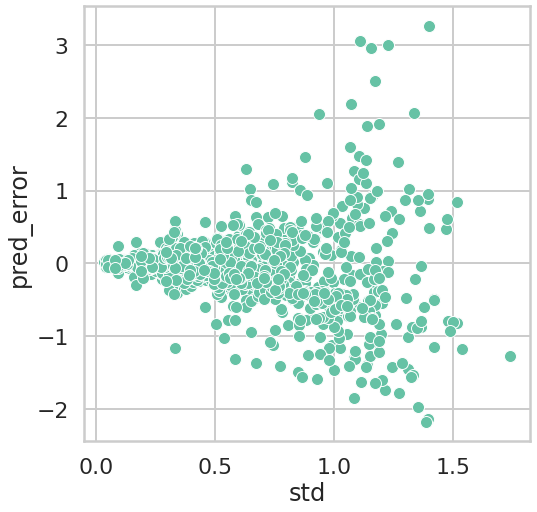

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=pred_df, x="std", y="pred_error", ax=ax)

### Grid search
#### Tunable parameters for Random Forest models
- rf_estimators: number of estimators to use in random forest models
- rf_max_depth: the maximum depth of a decision tree in the random forest
- rf_max_features: max number of features to split random forest nodes

## Time for running the following code chunk: ~ 10 minutes on COLAB-Pro

In [ ]:
param_choice = [16,32,64,128]

rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in param_choice:
    for rf_depth in param_choice:
        for rf_feature in param_choice:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['r2_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

# You will see output such as shown below:

```
2021-05-20 23:40:21,639 Previous dataset split restored
number of features: 1024
2021-05-20 23:40:22,145 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d14c9db0-5aec-4326-8b66-ebd60454786b/model_metadata.json
2021-05-20 23:40:22,159 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/d14c9db0-5aec-4326-8b66-ebd60454786b/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_d14c9db0-5aec-4326-8b66-ebd60454786b.tar.gz
rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3960169267773953
......
.......

2021-05-20 23:48:22,091 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1010b739-7736-4505-99c4-ba50b33d90df/model_metadata.json
2021-05-20 23:48:22,193 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/1010b739-7736-4505-99c4-ba50b33d90df/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_1010b739-7736-4505-99c4-ba50b33d90df.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4739461661466364

```



In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
55,128,32,128,0.478960
63,128,128,128,0.473946
19,32,16,128,0.470190
11,16,64,128,0.468356
23,32,32,128,0.461676
...,...,...,...,...
32,64,16,16,0.352474
1,16,16,32,0.350530
4,16,32,16,0.341084
12,16,128,16,0.325659


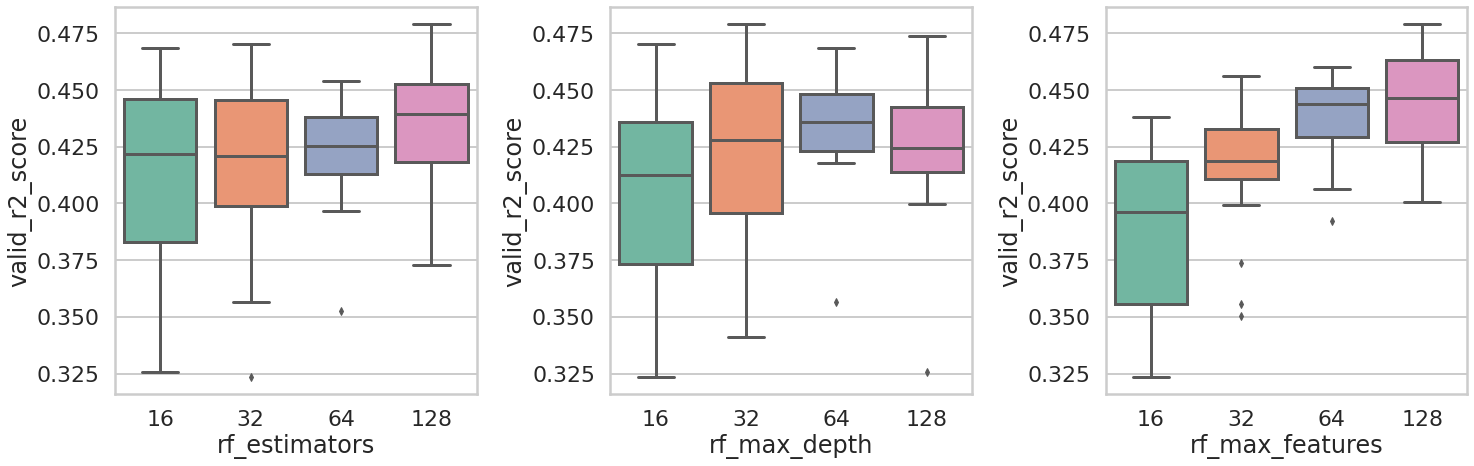

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

## Time for running the following code chunk: ~ 10 minutes on COLAB-Pro

### Random search

In [ ]:
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []

num_trials = 50

for i in range(num_trials):
    params["rf_estimators"] = np.random.randint(8,256)
    params["rf_max_depth"] = np.random.randint(8,256)
    params["rf_max_features"] = np.random.randint(8,256)
    rfe_list.append(params["rf_estimators"])
    rfd_list.append(params["rf_max_depth"])
    rff_list.append(params["rf_max_features"])
    tp = parse.wrapper(params)
    pl = mp.ModelPipeline(tp)
    pl.train_model()
    pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = pred_data.get_prediction_results()
    valid_r2 = pred_results['r2_score']
    valid_r2_list.append(valid_r2)
    print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

## Output from the above code chunk was deleted for clarity. Few lines of output are shown below for information.

```
021-05-20 23:48:29,932 Previous dataset split restored
number of features: 1024
2021-05-20 23:48:30,837 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a00e92de-6f13-4304-8fd5-eb2059dc1827/model_metadata.json
2021-05-20 23:48:30,891 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/a00e92de-6f13-4304-8fd5-eb2059dc1827/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_a00e92de-6f13-4304-8fd5-eb2059dc1827.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4531709372933693
2021-05-20 23:48:37,728 Previous dataset split restored
number of features: 1024
2021-05-20 23:48:38,394 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4fe38ff4-f72e-4fcb-8b24-b0ab5f90c38b/model_metadata.json
2021-05-20 23:48:38,432 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/4fe38ff4-f72e-4fcb-8b24-b0ab5f90c38b/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_4fe38ff4-f72e-4fcb-8b24-b0ab5f90c38b.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.44850337544269825

...
....
2021-05-20 23:55:05,063 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f2a9f900-e5aa-4b46-bfbe-dbff6dc60ae7/model_metadata.json
2021-05-20 23:55:05,158 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/f2a9f900-e5aa-4b46-bfbe-dbff6dc60ae7/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_f2a9f900-e5aa-4b46-bfbe-dbff6dc60ae7.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4447336201887926
2021-05-20 23:55:11,980 Previous dataset split restored
number of features: 1024
2021-05-20 23:55:13,133 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac340685-91a5-4864-a351-4a66c6f096b2/model_metadata.json
2021-05-20 23:55:13,254 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/ac340685-91a5-4864-a351-4a66c6f096b2/model_metrics.json
Wrote model tarball to ampl_output/H1_std_model_ac340685-91a5-4864-a351-4a66c6f096b2.tar.gz
rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.47147476253815945
```



In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": valid_r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
41,22,35,252,0.490220
43,218,233,236,0.478414
13,222,211,141,0.477369
2,240,134,247,0.473999
40,23,248,215,0.472263
49,152,72,53,0.471475
6,97,200,127,0.470279
34,197,85,235,0.469994
37,11,95,214,0.467105
27,139,115,134,0.465827


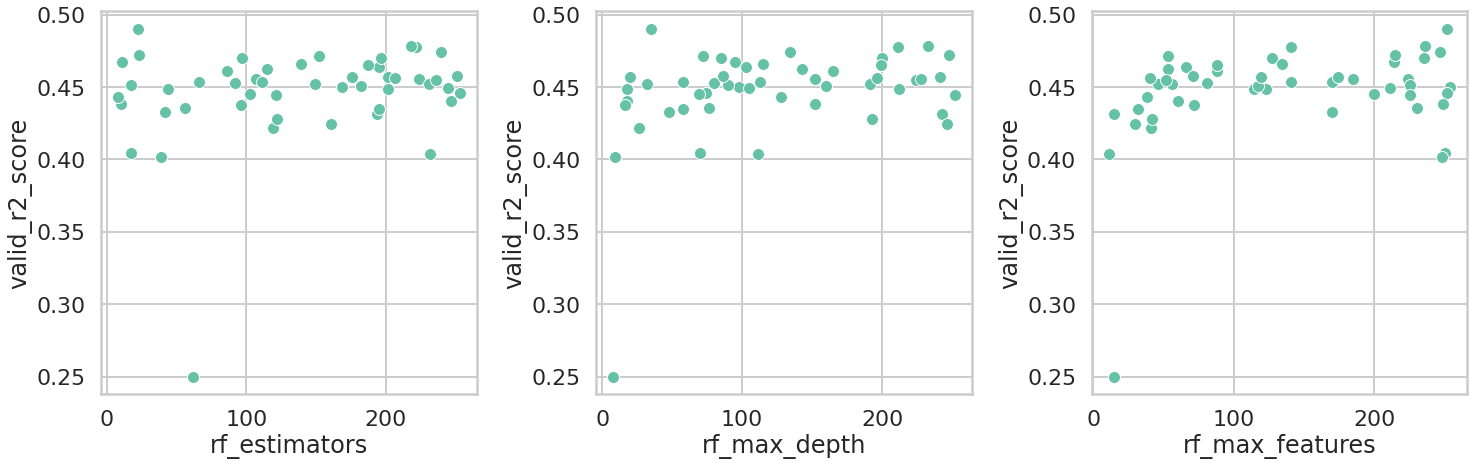

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.scatterplot(data=perf_df, x="rf_estimators", y="valid_r2_score", ax=ax[0])
sns.scatterplot(data=perf_df, x="rf_max_depth", y="valid_r2_score", ax=ax[1])
sns.scatterplot(data=perf_df, x="rf_max_features", y="valid_r2_score", ax=ax[2])
fig.tight_layout()

### Bayesian search

In [ ]:
#define loss function
def lossfn(p):
    params["rf_estimators"] = int(p["rf_estimator"])
    params["rf_max_depth"] = int(p["rf_depth"])
    params["rf_max_features"] = int(p["rf_feature"])
    
    tparam = parse.wrapper(params)
    pl = mp.ModelPipeline(tparam)
    pl.train_model()
    perf_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
    pred_results = perf_data.get_prediction_results()
    r2 = pred_results['r2_score']
    return {'loss': 1-r2, 
            'status': STATUS_OK, 
            'model': tparam.model_tarball_path, 
            'rf_estimator': params["rf_estimators"],
            'rf_depth': params["rf_max_depth"],
            'rf_feature': params["rf_max_features"]}

space = {
    "rf_estimator": hp.uniform("rf_estimator", 8, 256),
    "rf_depth": hp.uniform("rf_depth", 8, 256),
    "rf_feature": hp.uniform("rf_feature", 8, 256)
}

In [ ]:
trials = Trials()
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=5, trials=trials)

number of features: 1024
  0%|          | 0/5 [00:06<?, ?it/s, best loss: ?]

2021-05-20 23:55:21,050 Previous dataset split restored
2021-05-20 23:55:21,557 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f0f58e9-245b-4c49-9dbd-aa39aa4905a4/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_3f0f58e9-245b-4c49-9dbd-aa39aa4905a4.tar.gz
  0%|          | 0/5 [00:07<?, ?it/s, best loss: ?]

2021-05-20 23:55:21,574 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/3f0f58e9-245b-4c49-9dbd-aa39aa4905a4/model_metrics.json


number of features: 1024
 20%|██        | 1/5 [00:14<00:29,  7.38s/it, best loss: 0.539012919835863]

2021-05-20 23:55:28,520 Previous dataset split restored
2021-05-20 23:55:29,195 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5e59725e-993e-4c0b-a493-fc90c7480f56/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_5e59725e-993e-4c0b-a493-fc90c7480f56.tar.gz
 20%|██        | 1/5 [00:15<00:29,  7.38s/it, best loss: 0.539012919835863]

2021-05-20 23:55:29,243 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/5e59725e-993e-4c0b-a493-fc90c7480f56/model_metrics.json


number of features: 1024
 40%|████      | 2/5 [00:21<00:22,  7.47s/it, best loss: 0.539012919835863]

2021-05-20 23:55:36,168 Previous dataset split restored
2021-05-20 23:55:36,681 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b0162b01-786c-4461-806f-b7a4c6c0a453/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_b0162b01-786c-4461-806f-b7a4c6c0a453.tar.gz
 40%|████      | 2/5 [00:22<00:22,  7.47s/it, best loss: 0.539012919835863]

2021-05-20 23:55:36,702 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/b0162b01-786c-4461-806f-b7a4c6c0a453/model_metrics.json


number of features: 1024
 60%|██████    | 3/5 [00:29<00:14,  7.47s/it, best loss: 0.539012919835863]

2021-05-20 23:55:43,568 Previous dataset split restored
2021-05-20 23:55:45,014 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/63af8fb4-4ffc-4d38-8065-aa8a4cc8d822/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_63af8fb4-4ffc-4d38-8065-aa8a4cc8d822.tar.gz
 60%|██████    | 3/5 [00:30<00:14,  7.47s/it, best loss: 0.539012919835863]

2021-05-20 23:55:45,129 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/63af8fb4-4ffc-4d38-8065-aa8a4cc8d822/model_metrics.json


number of features: 1024
 80%|████████  | 4/5 [00:37<00:07,  7.75s/it, best loss: 0.5256434531695915]

2021-05-20 23:55:52,009 Previous dataset split restored
2021-05-20 23:55:53,052 Wrote model metadata to file ampl_output/H1_std/RF_ecfp_scaffold_regression/039b0772-11f5-4d5c-8ce8-178a733e79b3/model_metadata.json


Wrote model tarball to ampl_output/H1_std_model_039b0772-11f5-4d5c-8ce8-178a733e79b3.tar.gz
 80%|████████  | 4/5 [00:38<00:07,  7.75s/it, best loss: 0.5256434531695915]

2021-05-20 23:55:53,126 Wrote model metrics to file ampl_output/H1_std/RF_ecfp_scaffold_regression/039b0772-11f5-4d5c-8ce8-178a733e79b3/model_metrics.json


100%|██████████| 5/5 [00:38<00:00,  7.79s/it, best loss: 0.5256434531695915]


(0.2, 0.6)

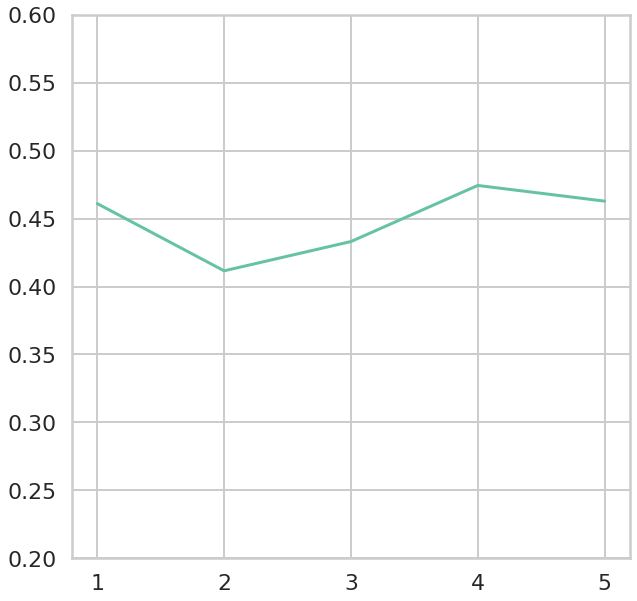

In [ ]:
r2_list = [1-trials.trials[i]["result"]["loss"] for i in range(len(trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [ ]:
rfe_list = [trials.trials[i]["result"]["rf_estimator"] for i in range(len(trials.trials))]
rfd_list = [trials.trials[i]["result"]["rf_depth"] for i in range(len(trials.trials))]
rff_list = [trials.trials[i]["result"]["rf_feature"] for i in range(len(trials.trials))]

In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
3,156,26,179,0.474357
4,87,201,163,0.462818
0,12,48,161,0.460987
2,13,177,143,0.433084
1,51,91,85,0.411533


#### Save Bayesian optimization trial object and continue later

In [ ]:
# save the trial object
trial_file = os.path.join("hp_trial.pkl")
with open(trial_file, "wb") as f:
    pickle.dump(trials, f)

In [ ]:
# load the trial object
with open(trial_file, "rb") as f:
    new_trials = pickle.load(f)

In [ ]:
# continue HPO
best = fmin(lossfn, space, algo=tpe.suggest, max_evals=50, trials=new_trials)

(0.2, 0.6)

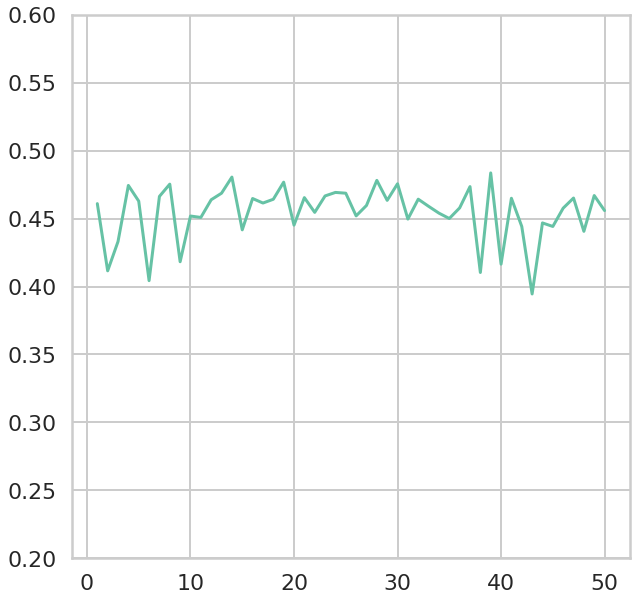

In [ ]:
r2_list = [1-new_trials.trials[i]["result"]["loss"] for i in range(len(new_trials.trials))]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(x=list(range(1,len(new_trials.trials)+1)), y=r2_list, ax=ax)
ax.set_ylim(0.2,0.6)

In [ ]:
rfe_list = [new_trials.trials[i]["result"]["rf_estimator"] for i in range(len(new_trials.trials))]
rfd_list = [new_trials.trials[i]["result"]["rf_depth"] for i in range(len(new_trials.trials))]
rff_list = [new_trials.trials[i]["result"]["rf_feature"] for i in range(len(new_trials.trials))]

In [ ]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_r2_score": r2_list})
perf_df.sort_values(by="valid_r2_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_r2_score
38,36,155,254,0.483576
13,168,217,177,0.480496
27,255,244,199,0.478098
18,190,246,237,0.476780
29,251,221,199,0.475595
7,112,146,140,0.475326
3,156,26,179,0.474357
36,63,106,112,0.473495
23,164,237,212,0.469228
12,90,124,54,0.468658


In [ ]:
!date

Fri May 21 00:03:30 UTC 2021
